In [1]:
# ---------------------------
# 0. Set Random Seed for Reproducibility
# ---------------------------
random_seed = 42

import random
import numpy as np
random.seed(random_seed)
np.random.seed(random_seed)

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# ---------------------------
# 1. Standard Python Libraries
# ---------------------------
import os, sys
import copy
import gc
from collections import Counter

# ---------------------------
# 2. Data Handling and Visualization
# ---------------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import cv2
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

# ---------------------------
# 3. Image Processing Libraries
# ---------------------------
from skimage.transform import resize
from skimage.measure import marching_cubes
from scipy.ndimage import gaussian_filter

# ---------------------------
# 4. PyTorch and Related Imports
# ---------------------------
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# ---------------------------
# 5. Torchvision
# ---------------------------
from torchvision import transforms, models

# ---------------------------
# 6. Scikit-learn
# ---------------------------
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, f1_score, precision_score,
                             recall_score, accuracy_score)

# ---------------------------
# 7. Einops
# ---------------------------
!pip install einops
import einops
from einops import rearrange

# ---------------------------
# 8. SciencePlots for Enhanced Matplotlib Styles
# ---------------------------
!pip install SciencePlots
import scienceplots
plt.style.use(['science', 'grid'])
plt.rcParams['figure.dpi'] = 500
plt.rcParams['text.usetex'] = False
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
})
DIR = f""
for dirname, _, filenames in os.walk(DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Model Import

Import model architectures defined in `models_classification.py` for use in training and evaluation.


In [2]:
sys.path.append(os.path.abspath(DIR))
from model_classification import (DepthwiseCNN3D, DepthwiseCNN3D, SimpleCNN, ChannelwiseCNNModel, DepthwiseSeparable3DResNet, ResViT, CNNViT)

In [ ]:
test_path = f"{DIR}/test_path"
train_path = f"{DIR}/train_path"
dose_csv = f"{DIR}/dose_csv"

# Dataset Definition

This section defines the dataset used for training and evaluation. It includes:

- **Data Import**: Loads the preprocessed PyTorch datasets from `preprocess.ipynb`.
- **Clinical Features**: Imports clinical data from a CSV file and applies normalization.
- **Data Augmentation & Splitting**: Performs augmentation techniques and splits the data into training, validation, and test sets.
- **Preprocessing**: Applies a Gaussian filter to the image data for smoothing.



In [4]:
# =====================================
# 1. Dataset Class
# =====================================
class GBMDataset3DLoaded(Dataset):
    def __init__(self,
                 data_list,
                 csv_path,
                 is_train=True,
                 image_transform=None,
                 clinical_transform=None,
                 augmentation_transform=None,
                 num_numerical_features=13):
        """
        Args:
            data_list: list of dicts, each with keys:
                'image':             Tensor or np.ndarray [3, D, H, W]
                'label':             0 or 1 (short vs long survival)
                'patient_id':        int or str
            csv_path:   path to dose_parameters CSV
            is_train:   whether to enable augmentation
            image_transform:    applied after augmentation
            clinical_transform: applied to the combined clinical tensor
            augmentation_transform: applied first on images
            num_numerical_features: how many leading elements of the clinical vector are numerical
        """
        super().__init__()
        self.data = data_list
        self.is_train = is_train
        self.image_transform = image_transform
        self.clinical_transform = clinical_transform
        self.augmentation_transform = augmentation_transform if is_train else None
        self.num_numerical = num_numerical_features

        # --- load CSV and preprocess clinical data ---
        df = pd.read_csv(csv_path)

        # 1) numerical features
        self.numerical_features = [
            'AgeAtStudyDate',
            'Days_between_surgery_and_RT',
            'prescription_dose',
            'num_fractions',
            'max_dose',
            'mean_dose',
            'V95',
            'V90',
            'V50',
            'V1',
            'brainstem_volume_cm3',
            'brainstem_mean_dose',
            'brainstem_max_dose',
        ]

        # 2) categorical one-hot encoding
        expected = {
            'Sex':   ["F","M"],
            'IDH1/2':["negative","positive","NaN"],
            'MGMT':  ["negative","positive","NaN"],
        }
        one_hot_cols = []
        for col, cats in expected.items():
            df[col] = df[col].astype(str).str.strip().replace(["nan","None",""],"NaN")
            for cat in cats:
                newcol = f"{col}_{cat}"
                df[newcol] = (df[col] == cat).astype(np.float32)
                one_hot_cols.append(newcol)
        self.categorical_features = one_hot_cols
        df.drop(columns=list(expected.keys()), inplace=True)

        # 3) fill missing numericals, replace -1
        df[self.numerical_features] = df[self.numerical_features].fillna(
            df[self.numerical_features].mean()
        )
        for col in self.numerical_features:
            m = df.loc[df[col] != -1, col].mean()
            df.loc[df[col] == -1, col] = m

        # 4) subset to patients present
        all_ids = [int(s['patient_id']) for s in data_list]
        subset = df[df['patient_id'].isin(all_ids)]
        if subset.empty:
            raise ValueError("No clinical data found for these patient IDs")

        # 5) compute mean & std
        self.num_mean = torch.tensor(
            subset[self.numerical_features].mean().values.astype(np.float32)
        )
        self.num_std  = torch.tensor(
            subset[self.numerical_features].std().values.astype(np.float32)
        )

        # 6) store full clinical table
        self.clinical_data = df.set_index('patient_id')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        img = sample['image']
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img, dtype=torch.float32)
        img = img.float()
        if self.augmentation_transform:
            img = self.augmentation_transform(img)
        if self.image_transform:
            img = self.image_transform(img)

        pid = int(sample['patient_id'])
        row = self.clinical_data.loc[pid]
        cat_vals = row[self.categorical_features].values.astype(np.float32)
        num_vals = row[self.numerical_features].values.astype(np.float32)
        clin = torch.from_numpy(np.concatenate([num_vals, cat_vals], axis=0)).float()
        if self.clinical_transform:
            clin = self.clinical_transform(clin)

        label = sample['label']
        if isinstance(label, torch.Tensor):
            label = label.long().item()
        elif isinstance(label, float):
            label = int(label)
        label = torch.tensor(label, dtype=torch.long)

        return {
            'image': img,
            'clinical_features': clin,
            'label': label,
            'patient_id': pid
        }

# =====================================
# 2. Transform Classes
# =====================================
class Normalize3D:
    def __init__(self, mean, std):
        self.mean = mean; self.std = std
    def __call__(self, x):
        m = self.mean.to(x.device).view(-1,1,1,1)
        s = self.std.to(x.device).view(-1,1,1,1)
        return (x.float() - m) / s

class NormalizeClinical:
    def __init__(self, mean, std, num_numerical):
        self.mean = mean; self.std = std; self.num_numerical = num_numerical
    def __call__(self, x):
        num = x[:self.num_numerical]
        cat = x[self.num_numerical:]
        num = (num - self.mean.to(x.device)) / self.std.to(x.device)
        return torch.cat([num, cat], dim=0)

class RandomFlip3D:
    def __init__(self, axes=(3,), p=0.5): self.axes, self.p = axes, p
    def __call__(self, x):
        for ax in self.axes:
            if random.random() < self.p:
                x = torch.flip(x, dims=[ax])
        return x

class GaussianFilter3D:
    def __init__(self, sigma, channels): self.sigma, self.channels = sigma, channels
    def __call__(self, x):
        arr = x.numpy()
        for c in self.channels:
            arr[c] = gaussian_filter(arr[c], sigma=self.sigma)
        return torch.from_numpy(arr)

class Compose3D:
    def __init__(self, transforms): self.transforms = transforms
    def __call__(self, x):
        for t in self.transforms:
            x = t(x)
        return x

# =====================================
# 3. Mean/Std Computation
# =====================================
def compute_mean_std_two_pass(dataset):
    loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0)
    n_ch = next(iter(loader))['image'].shape[1]
    total_sum = torch.zeros(n_ch); total_sq = torch.zeros(n_ch); total_vox = 0
    for b in loader:
        imgs = b['image']
        B,C,D,H,W = imgs.shape
        total_sum += imgs.sum(dim=(0,2,3,4)); total_vox += B*D*H*W
    mean = total_sum / total_vox
    for b in loader:
        diff = b['image'] - mean.view(1,-1,1,1,1)
        total_sq += (diff**2).sum(dim=(0,2,3,4))
    std = torch.sqrt((total_sq/total_vox).clamp(min=1e-6))
    return mean, std

# =====================================
# 4. Load, Split, Compute Stats & Build Datasets
# =====================================
# load your raw lists
train_list = torch.load(train_path, map_location='cpu')
test_list  = torch.load(test_path,  map_location='cpu')

all_list = train_list + test_list

labels   = [int(s['label']) for s in all_list]
train_list, test_list = train_test_split(
    all_list,
    test_size=0.2,
    random_state=random_seed,
    stratify=labels

# print the test IDs
print(f"Test set patient ids: {[int(s['patient_id']) for s in test_list]}")

# temp dataset to get image stats & clinical stats
temp_ds = GBMDataset3DLoaded(
    data_list=train_list,
    csv_path=dose_csv,
    is_train=False,
    image_transform=None,
    clinical_transform=None,
    augmentation_transform=None,
    num_numerical_features=13
)

# compute image mean & std
img_mean, img_std = compute_mean_std_two_pass(temp_ds)

# compute image mean & std
img_mean, img_std = compute_mean_std_two_pass(temp_ds)

# build transforms
image_transform = Compose3D([
    GaussianFilter3D(sigma=1, channels=[0,1,2]),
    Normalize3D(mean=img_mean, std=img_std)
])

clinical_transform = NormalizeClinical(
    mean=temp_ds.num_mean,
    std =temp_ds.num_std,
    num_numerical=13
)

aug_transform = RandomFlip3D(axes=(3,), p=1)

# create final datasets
train_dataset_augmented = GBMDataset3DLoaded(
    data_list=train_list,
    csv_path=dose_csv,
    is_train=True,
    image_transform=image_transform,
    clinical_transform=clinical_transform,
    augmentation_transform=aug_transform,
    num_numerical_features=13
)

train_dataset_non_augmented = GBMDataset3DLoaded(
    data_list=train_list,
    csv_path=dose_csv,
    is_train=True,
    image_transform=image_transform,
    clinical_transform=clinical_transform,
    augmentation_transform=None,
    num_numerical_features=13
)

test_dataset = GBMDataset3DLoaded(
    data_list=test_list,
    csv_path=dose_csv,
    is_train=False,
    image_transform=image_transform,
    clinical_transform=clinical_transform,
    augmentation_transform=None,
    num_numerical_features=13
)

print(f"Train size: {len(train_dataset_non_augmented)}")
print(f"Test size:  {len(test_dataset)}")

/tmp/ipykernel_30/256088092.py:330: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data_list = torch.load(train_path, map_location='cpu')
/tmp/ipykernel_30/256088092.py

Test dataset patient IDs: [110, 118, 171, 77, 18, 35, 166, 14, 72, 115, 105, 28, 112, 125, 59, 71, 3, 53]
Test patient IDs saved to test_patient_ids.csv
New training set size: 69
New test set size: 18
Image Mean: tensor([-5.4269e-08,  5.8055e-08, -2.6777e-08])
Image Std: tensor([1.0000, 1.0000, 1.0000])
Clinical Features Mean: tensor([-0.0211, -0.0490, -0.0193, -0.0509, -0.0348, -0.0583, -0.0043,  0.0190,
         0.0139, -0.0491])
Clinical Features Std: tensor([1.0100, 1.0795, 1.0545, 1.0804, 1.0411, 0.9631, 0.9805, 0.9652, 0.9473,
        0.8901])
Training dataset with augmentation size: 69
Training dataset without augmentation size: 69
Test dataset size: 18


# Visual Quality Check

Plot a sample of images from the dataset to inspect preprocessing quality


In [5]:
def plot_d_slices(samples, channels=[0, 1, 2]):
    num_samples = len(samples)
    num_channels = len(channels)

    fig, axes = plt.subplots(num_samples, num_channels, figsize=(5 * num_channels, 5 * num_samples))

    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)
    if num_channels == 1:
        axes = np.expand_dims(axes, axis=1)

    for i, sample in enumerate(samples):
        image = sample['image']
        label = sample['label']
        patient_id = sample['patient_id']

        C, D, H, W = image.shape
        print(image.shape)
        central_d = D // 2

        for j, c in enumerate(channels):
            channel_data = image[c].cpu().numpy()
            slice_d = channel_data[10, :, :]

            ax = axes[i, j]
            if c == 2:
              ax.imshow(slice_d, cmap='jet')
            else:
              ax.imshow(slice_d, cmap='gray')
            ax.set_title(f'Patient id {patient_id} - Channel {c+1}, Label {label}')
            ax.axis('off')

        # Legg til label som ylabel for hver rad
        axes[i,0].set_ylabel(f'Label: {label}', fontsize=12, rotation=0, labelpad=40, va='center')

    plt.tight_layout()
    plt.show()

num_samples_to_plot = 1
samples_to_plot = [train_dataset_augmented[i] for i in range(num_samples_to_plot)]

#plot_d_slices(samples_to_plot, channels=[0, 1, 2])

In [6]:
def depthwise_cnn_model(in_channels=3, num_classes=1, clinical_dim=16):
    """
    Factory function to create a DepthwiseCNN3D model with clinical data.

    Args:
        in_channels (int): Number of input channels for image data.
        num_classes (int): Number of output classes.
        clinical_dim (int): Dimension of the clinical data.

    Returns:
        An instance of DepthwiseCNN3D.
    """
    return DepthwiseCNN3D(in_channels=in_channels, num_classes=num_classes, clinical_dim=clinical_dim)


In [7]:
def simple_cnn_model(in_channels=2, num_classes=1, clinical_dim=21):
    """
    Factory function to create a SimpleCNN model.
    
    Args:
        in_channels (int): Number of image channels (e.g., 2 for T1 and T2).
        num_classes (int): Number of output classes.
        clinical_dim (int): Dimension of the clinical data.
    
    Returns:
        SimpleCNN: An instance of the SimpleCNN model.
    """
    return SimpleCNN(in_channels=in_channels, num_classes=num_classes, clinical_dim=clinical_dim)

In [8]:
def channelwise_cnn_model(num_image_channels=3, clinical_dim=21, num_classes=1):
    """
    Factory function to instantiate a ChannelwiseCNNModel.

    Args:
        num_image_channels (int): Number of image channels.
        clinical_dim (int): Dimension of the clinical data.
        num_classes (int): Number of output classes.
    Returns:
        An instance of ChannelwiseCNNModel.
    """
    return ChannelwiseCNNModel(num_image_channels=num_image_channels,
                               clinical_dim=clinical_dim,
                               num_classes=num_classes)

In [9]:
def depthwise_separable_3dresnet_model(clinical_dim=21, input_shape=(100, 256, 256), num_classes=1):
    model = DepthwiseSeparable3DResNet(clinical_dim=clinical_dim,
                                       input_shape=input_shape)
    return model

In [10]:
def res_vit_model(num_classes=1, clinical_dim=21):
    """
    Returns an instance of the ResViT model (Dual-branch 3D ResNet + ViT + clinical MLP).
    """
    return ResViT(num_classes=num_classes, clinical_dim=clinical_dim)

In [11]:
def cnn_vit(num_classes=1, clinical_dim=21):
    """
    Returns an instance of the CNNViT model.
    """
    return CNNViT(num_classes=num_classes, clinical_dim=clinical_dim)

# Model Training and Evaluation

## Training and Validation

The `train_and_validate` function orchestrates the full training loop for the binary classification task using PyTorch. It supports several model types and includes best-practice features for robustness and performance:

- **Model Selection**: Initializes the model dynamically from a factory based on `model_class` (e.g., `CNNViT`, `ResViT`, etc.).
- **Loss Function**: Binary cross-entropy with logits (`BCEWithLogitsLoss`) is used.
- **Optimization**:
  - Adam optimizer with weight decay
  - Learning rate scheduling using `ReduceLROnPlateau`
  - Optional gradient accumulation
  - Mixed precision training support via `torch.cuda.amp`
  - Gradient clipping to stabilize training
- **Training Loop**:
  - Calculates binary predictions and training accuracy
- **Validation Loop**:
  - Evaluates after each epoch if a validation loader is provided
  - Calculates validation loss, accuracy, ROC-AUC, F1 score, precision, and recall
  - Saves the best model based on validation accuracy (with ROC-AUC as a tie-breaker)
  - Includes early stopping based on validation performance

The function returns a dictionary with training results, including the best model path, validation metrics, and training success status.

---

## Model Evaluation

The `evaluate` function computes performance metrics for a trained model on a validation or test set:

- **Supports Mixed Precision**: Uses `torch.cuda.amp` if enabled
- **Handles Clinical-Only and Multi-Input Models**: Adjusts input formatting accordingly
- **Metrics Returned**:
  - Loss
  - Accuracy
  - ROC-AUC
  - F1 score
  - Precision
  - Recall


In [12]:
def train_and_validate(model_class, model_name, learning_rate, train_loader, val_loader, device,
                       num_classes=1, num_epochs=50, accumulation_steps=1, early_stopping_patience=15,
                       use_mixed_precision=True, clinical_dim=16):
    # Mapping from model_class string to factory functions
    model_factory = {
        'DepthwiseCNN3D': depthwise_cnn_model,
        'SimpleCNN' : simple_cnn_model,
        'ChannelwiseCNNModel': channelwise_cnn_model,
        'DepthwiseSeparable3DResNet': depthwise_separable_3dresnet_model,
        'ResViT': res_vit_model,
        'CNNViT' : cnn_vit
    }

    # Initialize the model based on model_class
    if model_class in model_factory:
        try:
            model = model_factory[model_class](num_classes=num_classes, clinical_dim=clinical_dim).to(device)
            print(f"Initialized model: {model_class} with num_classes={num_classes}")
        except Exception as e:
            print(f"Error initializing model {model_class}: {e}")
            raise e
    else:
        raise ValueError(f"Unknown model class: {model_class}")

    # Define loss function
    criterion = nn.BCEWithLogitsLoss()

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Define scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # Initialize GradScaler for mixed precision if enabled
    scaler = torch.GradScaler('cuda') if use_mixed_precision else None

    # Initialize variables to track best validation accuracy and loss
    best_val_acc = 0.0
    best_train_acc = 0.0  # Initialize Best Train Acc
    best_val_loss = float('inf')
    best_metrics = {}
    best_model_state = None
    best_model_path = None
    epochs_no_improve = 0
    training_success = True

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        optimizer.zero_grad()

        for i, batch in enumerate(train_loader):
            # Prepare data
            labels = batch['label'].float().unsqueeze(1).to(device)
            clinical_data = batch['clinical_features'].float().to(device)
            if model_class != 'ClinicalOnlyModel':
                dose_images = batch['image'].to(device)

            # Check for NaN in input data
            if torch.isnan(labels).any() or torch.isnan(clinical_data).any() or \
               (model_class != 'ClinicalOnlyModel' and torch.isnan(dose_images).any()):
                print(f"NaN detected in training data at batch {i+1}. Skipping this batch.")
                continue

            # Determine inputs based on model
            if model_class == 'ClinicalOnlyModel':
                inputs = clinical_data
            else:
                inputs = (dose_images, clinical_data)

            # Forward pass with mixed precision if enabled
            try:
                if use_mixed_precision:
                    with torch.autocast('cuda'):
                        outputs = model(inputs) if model_class == 'ClinicalOnlyModel' else model(*inputs)
                        loss = criterion(outputs, labels) / accumulation_steps
                else:
                    outputs = model(inputs) if model_class == 'ClinicalOnlyModel' else model(*inputs)
                    loss = criterion(outputs, labels) / accumulation_steps
            except Exception as e:
                print(f"Exception during forward pass at epoch {epoch+1}, batch {i+1}: {e}")
                training_success = False
                break

            # Check for NaN in loss
            if torch.isnan(loss):
                print(f"NaN detected in loss at epoch {epoch+1}, batch {i+1}. Stopping training.")
                training_success = False
                break

            # Backward pass
            if use_mixed_precision:
                scaler.scale(loss).backward()
            else:
                loss.backward()

            # Gradient accumulation and optimizer step
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                # Gradient Clipping
                if use_mixed_precision:
                    scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                if use_mixed_precision:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad()

            # Accumulate training loss
            train_loss += loss.item() * accumulation_steps * labels.size(0)

            # Calculate training accuracy
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        if not training_success:
            print("Training interrupted due to errors.")
            break  # Stop training early

        # Compute average training loss and accuracy
        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / total_train

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            y_true = []
            y_pred = []
            y_scores = []

            with torch.no_grad():
                for batch_idx, batch in enumerate(val_loader):
                    labels = batch['label'].float().unsqueeze(1).to(device)
                    clinical_data = batch['clinical_features'].float().to(device)
                    if model_class != 'ClinicalOnlyModel':
                        dose_images = batch['image'].to(device)

                    # Check for NaN in input data
                    if torch.isnan(labels).any() or torch.isnan(clinical_data).any() or \
                       (model_class != 'ClinicalOnlyModel' and torch.isnan(dose_images).any()):
                        print(f"NaN detected in validation data at batch {batch_idx+1}. Skipping this batch.")
                        continue

                    # Determine inputs based on model
                    if model_class == 'ClinicalOnlyModel':
                        inputs = clinical_data
                    else:
                        inputs = (dose_images, clinical_data)

                    # Forward pass with mixed precision if enabled
                    try:
                        if use_mixed_precision:
                            with torch.autocast('cuda'):
                                outputs = model(inputs) if model_class == 'ClinicalOnlyModel' else model(*inputs)
                                loss = criterion(outputs, labels)
                        else:
                            outputs = model(inputs) if model_class == 'ClinicalOnlyModel' else model(*inputs)
                            loss = criterion(outputs, labels)
                    except Exception as e:
                        print(f"Exception during validation forward pass at batch {batch_idx+1}: {e}")
                        continue

                    # Accumulate validation loss
                    val_loss += loss.item() * labels.size(0)

                    # Calculate probabilities and predictions
                    probs = torch.sigmoid(outputs)
                    preds = (probs >= 0.5).float()

                    # Check for NaN in outputs
                    if torch.isnan(probs).any() or torch.isnan(preds).any():
                        print(f"NaN detected in model outputs at validation batch {batch_idx+1}. Skipping this batch.")
                        continue

                    # Accumulate correct predictions and total samples
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

                    # Collect true labels and predictions for metrics
                    y_true.extend(labels.cpu().numpy().flatten())
                    y_pred.extend(preds.cpu().numpy().flatten())
                    y_scores.extend(probs.cpu().numpy().flatten())

            if not training_success:
                break  # Stop training early

            # Compute average validation loss and accuracy
            if total > 0:
                average_val_loss = val_loss / len(val_loader.dataset)
                val_acc = correct / total
            else:
                average_val_loss = float('nan')
                val_acc = float('nan')
                print("All validation batches were skipped due to NaN values.")

            # Calculate additional evaluation metrics
            if len(set(y_true)) > 1 and len(y_true) > 0:
                try:
                    roc_auc = roc_auc_score(y_true, y_scores)
                except ValueError as e:
                    print(f"Error calculating ROC-AUC: {e}")
                    roc_auc = float('nan')
                f1 = f1_score(y_true, y_pred, zero_division=0)
                precision = precision_score(y_true, y_pred, zero_division=0)
                recall = recall_score(y_true, y_pred, zero_division=0)
            else:
                roc_auc = float('nan')  # ROC-AUC is not defined for single-class
                f1 = 0.0
                precision = 0.0
                recall = 0.0

            # Update learning rate scheduler based on validation loss
            if not np.isnan(average_val_loss):
                scheduler.step(average_val_loss)

            # Check if current validation accuracy is the best so far,
            # and if equal, use ROC-AUC as tie-breaker.
            if (not np.isnan(val_acc)) and (val_acc > best_val_acc or (val_acc == best_val_acc and roc_auc > best_metrics.get('ROC-AUC', -1))):
                best_val_acc = val_acc
                best_train_acc = train_acc  # Update Best Train Acc
                best_val_loss = average_val_loss
                best_metrics = {
                    'Val Loss': average_val_loss,
                    'Val Accuracy': val_acc,
                    'ROC-AUC': roc_auc,
                    'F1-Score': f1,
                    'Precision': precision,
                    'Recall': recall
                }
                best_model_state = model.state_dict()
                best_model_path = f'best_{model_name}_lr_{learning_rate}_epoch_{epoch+1}.pth'
                torch.save(best_model_state, best_model_path)
                print(f"New best model: Val Acc: {best_val_acc:.4f}, ROC-AUC: {roc_auc:.4f} at epoch {epoch+1}. Model saved as {best_model_path}")
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            # Print epoch summary
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
                  f'Val Loss: {average_val_loss:.4f}, Val Acc: {val_acc:.4f}, '
                  f'ROC-AUC: {roc_auc:.4f}, F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

            # Early stopping condition
            if epochs_no_improve >= early_stopping_patience:
                print(f'Early stopping triggered after {epoch+1} epochs with no improvement.')
                break

        else:
            # If val_loader is None, skip validation and save the model at the end
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            # Optionally, save the model every few epochs
            if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
                model_state = model.state_dict()
                model_path = f'best_{model_name}_lr_{learning_rate}_epoch_{epoch+1}.pth'
                torch.save(model_state, model_path)
                print(f"Model saved at epoch {epoch+1} as {model_path}")

        # Clean up to free memory
        del labels, clinical_data, outputs, loss, probs, preds
        if model_class != 'ClinicalOnlyModel':
            del dose_images
        gc.collect()
        if device == 'cuda':
            torch.cuda.empty_cache()

    # Prepare and return training results
    if training_success:
        if val_loader is not None and best_model_path is not None:
            # Return best validation results
            return {
                'Model': model_name,
                'Learning Rate': learning_rate,
                'Best Val Acc': best_val_acc,
                'Best Train Acc': best_train_acc,  # Include Best Train Acc
                'Best Val Loss': best_val_loss,
                'Best Metrics': best_metrics,
                'Best Model Path': best_model_path,
                'success': True
            }
        else:
            # For retraining without validation
            final_model_state = model.state_dict()
            final_model_path = f'best_{model_name}_lr_{learning_rate}_final.pth'
            torch.save(final_model_state, final_model_path)
            return {
                'Model': model_name,
                'Learning Rate': learning_rate,
                'Best Val Acc': None,
                'Best Train Acc': train_acc,  # Assign final train_acc
                'Best Val Loss': None,
                'Best Metrics': {},
                'Best Model Path': final_model_path,
                'success': True
            }
    else:
        return {
            'Model': model_name,
            'Learning Rate': learning_rate,
            'Best Val Acc': best_val_acc,
            'Best Train Acc': best_train_acc,
            'Best Val Loss': best_val_loss,
            'Best Metrics': best_metrics,
            'Best Model Path': best_model_path,
            'success': False
        }

def evaluate(model, dataloader, device, threshold=0.5, use_mixed_precision=True, model_class=None):
    """
    Evaluate a given model on an evaluation set and return relevant metrics.

    Args:
        model (nn.Module): The trained model to be evaluated.
        dataloader (DataLoader): DataLoader for the evaluation set.
        device (torch.device): The device (CPU or GPU) where evaluation will be performed.
        threshold (float, optional): Classification threshold for binary classification. Default is 0.5.
        use_mixed_precision (bool, optional): Whether to use mixed precision. Default is True.
        model_class (str, optional): The class name of the model. Used to determine input handling.

    Returns:
        dict: A dictionary containing evaluation metrics.
    """
    model.eval()  # Set the model to evaluation mode
    criterion = nn.BCEWithLogitsLoss()

    val_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            labels = batch['label'].float().unsqueeze(1).to(device)
            clinical_data = batch['clinical_features'].float().to(device)
            if model_class != 'ClinicalOnlyModel':
                dose_images = batch['image'].to(device)

            # Check for NaN in input data
            if torch.isnan(labels).any() or torch.isnan(clinical_data).any() or \
               (model_class != 'ClinicalOnlyModel' and torch.isnan(dose_images).any()):
                print(f"NaN detected in evaluation data at batch {batch_idx+1}. Skipping this batch.")
                continue

            # Determine inputs based on model
            if model_class == 'ClinicalOnlyModel':
                inputs = clinical_data
            else:
                inputs = (dose_images, clinical_data)

            # Forward pass with mixed precision if enabled
            try:
                if use_mixed_precision:
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs) if model_class == 'ClinicalOnlyModel' else model(*inputs)
                        loss = criterion(outputs, labels)
                else:
                    outputs = model(inputs) if model_class == 'ClinicalOnlyModel' else model(*inputs)
                    loss = criterion(outputs, labels)
            except Exception as e:
                print(f"Exception during evaluation forward pass at batch {batch_idx+1}: {e}")
                continue

            # Accumulate validation loss
            val_loss += loss.item() * labels.size(0)

            # Calculate probabilities and predictions
            probs = torch.sigmoid(outputs)
            preds = (probs >= threshold).float()

            # Check for NaN in outputs
            if torch.isnan(probs).any() or torch.isnan(preds).any():
                print(f"NaN detected in model outputs at evaluation batch {batch_idx+1}. Skipping this batch.")
                continue

            # Accumulate correct predictions and total samples
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Collect true labels and predictions for metrics
            y_true.extend(labels.cpu().numpy().flatten())
            y_pred.extend(preds.cpu().numpy().flatten())
            y_scores.extend(probs.cpu().numpy().flatten())

    if len(dataloader.dataset) > 0:
        val_loss /= len(dataloader.dataset)
    else:
        val_loss = float('nan')
        print("The evaluation dataset is empty.")

    if total > 0:
        val_acc = correct / total
    else:
        val_acc = float('nan')
        print("No valid predictions were made during evaluation.")

    if len(set(y_true)) > 1 and len(y_true) > 0:
        try:
            roc_auc = roc_auc_score(y_true, y_scores)
        except ValueError as e:
            print(f"Error calculating ROC-AUC: {e}")
            roc_auc = float('nan')
        f1 = f1_score(y_true, y_pred, zero_division=0)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
    else:
        roc_auc = float('nan')
        f1 = 0.0
        precision = 0.0
        recall = 0.0

    accuracy = accuracy_score(y_true, y_pred)

    metrics = {
        'Val Loss': val_loss,
        'Accuracy': val_acc,
        'ROC-AUC': roc_auc,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy
    }

    return metrics


In [13]:

def initialize_model(model_class, num_classes, clinical_dim, device):
    """
    Initializes and returns a model instance based on the model_class name.

    Args:
        model_class (str): Name of the model class to initialize.
        num_classes (int): Number of output classes.
        clinical_dim (int): Dimension of clinical features.
        device (str or torch.device): Device on which to load the model.

    Returns:
        torch.nn.Module: Initialized model loaded on the specified device.
    """
    if model_class == 'DepthwiseSeparable3DResNet':
        model = depthwise_separable_3dresnet_model(
            num_classes=num_classes,
            clinical_dim=clinical_dim
        )
    elif model_class == 'DepthwiseCNN3D':
        model = depthwise_cnn_model(
            num_classes=num_classes,
            clinical_dim=clinical_dim
        )
    elif model_class == 'SimpleCNN':
        model = simple_cnn_model(
            num_classes=num_classes,
            clinical_dim=clinical_dim
        )
    elif model_class == 'ChannelSeparatedCNN':
        model = channelwise_cnn_model(
            num_classes=num_classes,
            clinical_dim=clinical_dim
        )
    elif model_class == 'ResViT':
        model = res_vit_model(
            num_classes=num_classes,
            clinical_dim=clinical_dim
        )
    elif model_class == 'CNNViT':
        model = cnn_vit(
            num_classes=num_classes,
            clinical_dim=clinical_dim
        )
    else:
        raise ValueError(f"Unknown model class: {model_class}")

    # Move the model to the specified device
    return model.to(device)

# Model classes to evaluate
model_classes = ['DepthwiseSeparable3DResNet', 'CNNViT', 'ChannelwiseCNNModel', 'DepthwiseCNN3D']
learning_rates = [1e-4, 1e-5]

# Batch size mapping for each model
batch_size_mapping = {
    'SimpleCNN': 4,
    'DepthwiseCNN3D': 4,
    'ChannelwiseCNNModel': 4,
    'DepthwiseSeparable3DResNet': 4,
    'ResViT': 2,
    'CNNViT' : 2
}

# Container for results
train_val_results = []
all_fold_results = []

# Cross-validation and training parameters
num_classes = 1
num_epochs = 30
accumulation_steps = 8
early_stopping_patience = 5
clinical_dim = 21
max_retries = 3
n_splits = 5


labels = [sample['label'] for sample in train_dataset_non_augmented]
labels = np.array(labels)

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

# Flag to control training vs. loading
train_flag = False  # Set to True to train models, False to load a previously trained model

if train_flag:
    # ---------------------
    # Training Block
    # ---------------------
    for model_class in model_classes:
        batch_size = batch_size_mapping.get(model_class, 4)

        for lr in learning_rates:
            fold_results = []
            for fold, (train_indices, val_indices) in enumerate(skf.split(np.zeros(len(labels)), labels)):
                print(f'\n--- Training {model_class} with learning rate {lr}, Fold {fold+1}/{n_splits} ---')

                # Create training and validation subsets
                fold_train_subset = Subset(train_dataset_augmented, train_indices) + Subset(train_dataset_non_augmented, train_indices)
                fold_val_subset = Subset(train_dataset_non_augmented, val_indices)

                # Create DataLoaders
                train_loader = DataLoader(
                    fold_train_subset,
                    batch_size=batch_size,
                    shuffle=False,
                    num_workers=4,
                    pin_memory=True
                )
                val_loader = DataLoader(
                    fold_val_subset,
                    batch_size=batch_size,
                    shuffle=False,
                    num_workers=4,
                    pin_memory=True
                )

                attempt = 0
                success = False
                while attempt < max_retries and not success:
                    # train_and_validate is assumed to be already defined or imported
                    result = train_and_validate(
                        model_class=model_class,
                        model_name=model_class,
                        learning_rate=lr,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        device=device,
                        num_classes=num_classes,
                        num_epochs=num_epochs,
                        accumulation_steps=accumulation_steps,
                        early_stopping_patience=early_stopping_patience,
                        use_mixed_precision=True,
                        clinical_dim=clinical_dim
                    )

                    if result.get('success', False):
                        success = True
                        print(f"Training succeeded on attempt {attempt+1}")
                        result['Model Class'] = model_class
                        result['Learning Rate'] = lr
                        result['Batch Size'] = batch_size
                        result['Fold'] = fold + 1
                        fold_results.append(result)
                        all_fold_results.append(result)
                    else:
                        print(f"Training failed on attempt {attempt+1} for {model_class} with LR {lr}, Fold {fold+1}. Retrying...")
                        attempt += 1

                if not success:
                    print(f"Training {model_class} with learning rate {lr} failed after {max_retries} attempts on Fold {fold+1}.")

                # Empty CUDA cache after each fold to free up memory
                if device == 'cuda':
                    torch.cuda.empty_cache()

            # Calculate average results over the folds for this model+lr
            if fold_results:
                avg_val_acc = np.mean([res['Best Val Acc'] for res in fold_results])
                avg_train_acc = np.mean([res['Best Train Acc'] for res in fold_results])
                avg_val_loss = np.mean([res['Best Val Loss'] for res in fold_results])

                avg_metrics = {}
                metric_keys = ['Val Loss', 'Val Accuracy', 'ROC-AUC', 'F1-Score', 'Precision', 'Recall']
                for key in metric_keys:
                    vals = [res['Best Metrics'][key] for res in fold_results if res['Best Metrics'].get(key) is not None]
                    if len(vals) > 0:
                        avg_metrics[key] = np.mean(vals)
                    else:
                        avg_metrics[key] = None

                print(f"Average Validation Accuracy for {model_class} with LR {lr}: {avg_val_acc:.4f}")
                print(f"Average Training Accuracy for {model_class} with LR {lr}: {avg_train_acc:.4f}")

                avg_result = {
                    'Model': model_class,
                    'Learning Rate': lr,
                    'Average Val Acc': avg_val_acc,
                    'Average Train Acc': avg_train_acc,
                    'Average Val Loss': avg_val_loss,
                    'Average Metrics': avg_metrics,
                    'success': True
                }
                train_val_results.append(avg_result)
            else:
                avg_result = {
                    'Model': model_class,
                    'Learning Rate': lr,
                    'Average Val Acc': None,
                    'Average Train Acc': None,
                    'Average Val Loss': None,
                    'Average Metrics': None,
                    'success': False
                }
                train_val_results.append(avg_result)

    # Convert results to DataFrame
    train_val_results_df = pd.DataFrame(train_val_results)
    print("\nTraining and Validation Results:")
    print(train_val_results_df)

    # --------------------------------------------------------
    # Identify the Best Model from Cross-Validation
    # --------------------------------------------------------
    best_result = None
    highest_val_acc = 0.0

    for result in all_fold_results:
        current_val_acc = result['Best Val Acc']
        current_roc_auc = result['Best Metrics']['ROC-AUC']

        # Check if this result is better
        if current_val_acc > highest_val_acc:
            highest_val_acc = current_val_acc
            best_result = result
        elif current_val_acc == highest_val_acc:
            # If val_accuracy is equal, choose the model with the higher ROC-AUC
            if best_result is None or current_roc_auc > best_result['Best Metrics']['ROC-AUC']:
                best_result = result

    if best_result is not None:
        print(f"\nBest Model Found:")
        print(f"Model Class: {best_result['Model Class']}")
        print(f"Learning Rate: {best_result['Learning Rate']}")
        print(f"Batch Size: {best_result['Batch Size']}")
        print(f"Fold: {best_result['Fold']}")
        print(f"Validation Accuracy: {best_result['Best Val Acc']:.4f}")
        print(f"Best Model Path: {best_result['Best Model Path']}")

        # -----------------------------------------
        # Load and Evaluate Best Model on Test Set
        # -----------------------------------------
        # Initialize the best model
        best_model_class = best_result['Model Class']
        best_model_path = best_result['Best Model Path']

        # Reload the best model
        best_model = initialize_model(best_model_class, num_classes, clinical_dim, device)
        best_model.load_state_dict(torch.load(best_model_path, map_location=device))
        best_model.to(device)

        # Create a test DataLoader (Assumes test_dataset_non_augmented is defined)
        # You can change 'batch_size' or 'num_workers' as needed.
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size_mapping.get(best_model_class, 4),
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

        # Evaluate on the test set
        test_metrics = evaluate(best_model, test_loader, device)

        print("\n--- Test Metrics for the Best Model ---")
        for k, v in test_metrics.items():
            print(f"{k}: {v}")

    else:
        print("No model was successfully trained.")

else:
    # ---------------------
    # Load a Pretrained Model
    # ---------------------
    pretrained_model_class = 'CNNViT' 
    pretrained_model_path = '{DIR}/best_CNNViT_survival.pth'

    # Initialize the model
    try:
        model = initialize_model(pretrained_model_class, num_classes, clinical_dim, device)
        print(f"Initializing model: {pretrained_model_class}")
    except ValueError as e:
        print(e)
        raise

    # Load the model state
    try:
        model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
        print(f"Loaded pretrained model from {pretrained_model_path}")
    except Exception as e:
        print(f"Failed to load the model state: {e}")
        raise

    model.to(device)
    model.eval()

    # For consistency, add info to train_val_results_df
    train_val_results = [{
        'Model': pretrained_model_class,
        'Learning Rate': None,
        'Average Val Acc': None,
        'Average Train Acc': None,
        'Average Val Loss': None,
        'Average Metrics': None,
        'success': True
    }]
    train_val_results_df = pd.DataFrame(train_val_results)

    # Example of evaluating this loaded model on a test set
    test_loader = DataLoader(
        test_dataset, 
        batch_size=4,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    test_metrics = evaluate(model, test_loader, device)
    print("\n--- Test Metrics for the Pretrained Model ---")
    for k, v in test_metrics.items():
        print(f"{k}: {v}")

# Filter successful training results
successful_results_df = train_val_results_df[train_val_results_df['success'] == True]

Initializing model: CNNViT


/tmp/ipykernel_30/1825593990.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_model_path, map_location=device))


Loaded pretrained model from /kaggle/input/cnnvit-survival-model/pytorch/default/1/best_CNNViT_lr_0.0001_epoch_4.pth


/tmp/ipykernel_30/3317861193.py:364: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



--- Test Metrics for the Pretrained Model ---
Val Loss: 0.9108219544092814
Accuracy: 0.8333333333333334
ROC-AUC: 0.8271604938271605
F1-Score: 0.8421052631578948
Precision: 0.8
Recall: 0.8888888888888888


In [ ]:
successful_results_df = train_val_results_df[train_val_results_df['success'] == True]

# For each model, select the result with the highest Average Val Acc
best_results = successful_results_df.loc[successful_results_df.groupby('Model')['Average Val Acc'].idxmax()]

# Extract data for plotting
models = best_results['Model'].values
train_acc = best_results['Average Train Acc'].values
val_acc = best_results['Average Val Acc'].values
learning_rates = best_results['Learning Rate'].values

# Set positions and width for the bars
x = np.arange(len(models))
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

rects1 = ax.bar(x - width/2, train_acc, width, label='Train Accuracy')
rects2 = ax.bar(x + width/2, val_acc, width, label='Validation Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Best Train and Validation Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Annotate the bars with the best learning rate for each model
for i, lr in enumerate(learning_rates):
    # Place the annotation at the top of the validation accuracy bar (you could also use train_acc)
    ax.text(x[i] + width/2, val_acc[i] + 0.005, f"lr: {lr:.0e}", ha='center', va='bottom', fontsize=9)

fig.tight_layout()
plt.savefig(f'{DIR}/train_survival_models.pdf')
plt.show()

KeyError: "None of [Index([nan], dtype='float64')] are in the [index]"

In [14]:
tune_flag = False
if tune_flag:
    best_model_class = best_result['Model Class']
    best_lr = best_result['Learning Rate']
    best_batch_size = best_result['Batch Size']

    print(f"Tuning the best model: {best_model_class} (initially LR={best_lr}, Batch Size={best_batch_size})")

    train_size = int(0.8 * len(train_dataset_non_augmented))
    val_size = len(train_dataset_non_augmented) - train_size
    tune_train_dataset, tune_val_dataset = random_split(
        train_dataset_non_augmented, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(random_seed)
    )

    # Possible hyperparameters to tune
    accumulation_steps_list = [1, 5]
    batch_size_list = [2, 4]
    learning_rate_list = [1e-4, 1e-5]

    # We'll store tuning results here
    tuning_results = []

    # Loop over hyperparameter combos
    for acc_steps in accumulation_steps_list:
        for bs in batch_size_list:
            for lr in learning_rate_list:
                print(f"\n=== Tuning Combo: LR={lr}, BatchSize={bs}, AccSteps={acc_steps} ===")

                # Build DataLoaders
                tune_train_loader = DataLoader(
                    tune_train_dataset,
                    batch_size=bs,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=True
                )
                tune_val_loader = DataLoader(
                    tune_val_dataset,
                    batch_size=bs,
                    shuffle=False,
                    num_workers=4,
                    pin_memory=True
                )

                # Train the best model with these hyperparameters
                result = train_and_validate(
                    model_class=best_model_class,
                    model_name=f"{best_model_class}_tuned",
                    learning_rate=lr,
                    train_loader=tune_train_loader,
                    val_loader=tune_val_loader,
                    device=device,
                    num_classes=num_classes,
                    num_epochs=num_epochs,  # You can reduce epochs if you want faster tuning
                    accumulation_steps=acc_steps,
                    early_stopping_patience=early_stopping_patience,
                    use_mixed_precision=True,
                    clinical_dim=clinical_dim
                )

                # Record the tuning outcome
                tuning_results.append({
                    'Model Class': best_model_class,
                    'LR': lr,
                    'Batch Size': bs,
                    'Accumulation Steps': acc_steps,
                    'Best Val Acc': result['Best Val Acc'],
                    'Best Val Loss': result['Best Val Loss'],
                    'Best Metrics': result['Best Metrics'],
                    'Best Model Path': result.get('Best Model Path', None)
                })

    # Sort tuning_results by best validation accuracy (descending) and print top results
    tuning_results_sorted = sorted(tuning_results, key=lambda x: x['Best Val Acc'], reverse=True)
    best_tuned = tuning_results_sorted[0]
    print("\n--- Tuning Completed ---")
    print("Top Tuning Result:")
    print(best_tuned)

In [15]:

# =====================================================
# 3) Evaluate the Best Tuned Model on the Test Dataset
# =====================================================

# 'best_tuned' is the top result from the tuning procedure.
if 'best_tuned' in globals() and best_tuned.get('Best Model Path', None) is not None:
    best_tuned_model_class = best_tuned['Model Class']
    best_tuned_model_path = best_tuned['Best Model Path']
    best_tuned_lr = best_tuned['LR']
    best_tuned_batch_size = best_tuned['Batch Size']
    best_tuned_acc_steps = best_tuned['Accumulation Steps']

    print(f"\n--- Evaluating Best Tuned Model ---")
    print(f"Model Class: {best_tuned_model_class}")
    print(f"Learning Rate: {best_tuned_lr}")
    print(f"Batch Size: {best_tuned_batch_size}")
    print(f"Accumulation Steps: {best_tuned_acc_steps}")
    print(f"Model Path: {best_tuned_model_path}")

    if os.path.exists(best_tuned_model_path):
        # Initialize and load the best tuned model
        best_tuned_model = initialize_model(best_tuned_model_class, num_classes, clinical_dim, device)
        best_tuned_model.load_state_dict(torch.load(best_tuned_model_path, map_location=device))
        best_tuned_model.to(device)
        best_tuned_model.eval()

        test_loader = DataLoader(
            test_dataset,
            batch_size=best_tuned_batch_size,
            shuffle=False,
            num_workers=6,
            pin_memory=True
        )

        # Evaluate
        test_metrics_tuned = evaluate(
            best_tuned_model,
            test_loader,
            device,
            threshold=0.5,
            model_class=best_tuned_model_class
        )

        print("\nTest Metrics for the Best Tuned Model:")
        for metric_name, metric_value in test_metrics_tuned.items():
            print(f"{metric_name}: {metric_value:.4f}")
    else:
        print(f"Model path '{best_tuned_model_path}' does not exist. Cannot load the model.")
else:
    print("No tuned model found or no valid 'Best Model Path' to evaluate.\n Using pre-trained mode")
    
    # ---------------------
    # Load a Pretrained Model (If not training)
    # ---------------------
    pretrained_model_class = 'CNNViT'
    pretrained_model_path = '{DIR}/best_CNNViT_survival.pth'

    # Initialize the model
    try:
        model = initialize_model(pretrained_model_class, num_classes, clinical_dim, device)
        print(f"Initializing model: {pretrained_model_class}")
    except ValueError as e:
        print(e)
        raise

    # Load the model state
    try:
        model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
        print(f"Loaded pretrained model from {pretrained_model_path}")
    except Exception as e:
        print(f"Failed to load the model state: {e}")
        raise

    model.to(device)
    model.eval()

Patient id tensor([110]): True label = tensor([1], device='cuda:0')
Predicted: tensor([1], device='cuda:0') for patient id tensor([110])
Batch 1/18 processed.
Patient id tensor([118]): True label = tensor([0], device='cuda:0')
Predicted: tensor([1], device='cuda:0') for patient id tensor([118])
Batch 2/18 processed.
Patient id tensor([171]): True label = tensor([0], device='cuda:0')
Predicted: tensor([0], device='cuda:0') for patient id tensor([171])
Batch 3/18 processed.
Patient id tensor([77]): True label = tensor([1], device='cuda:0')
Predicted: tensor([1], device='cuda:0') for patient id tensor([77])
Batch 4/18 processed.
Patient id tensor([18]): True label = tensor([1], device='cuda:0')
Predicted: tensor([1], device='cuda:0') for patient id tensor([18])
Batch 5/18 processed.
Patient id tensor([35]): True label = tensor([1], device='cuda:0')
Predicted: tensor([1], device='cuda:0') for patient id tensor([35])
Batch 6/18 processed.
Patient id tensor([166]): True label = tensor([0], d

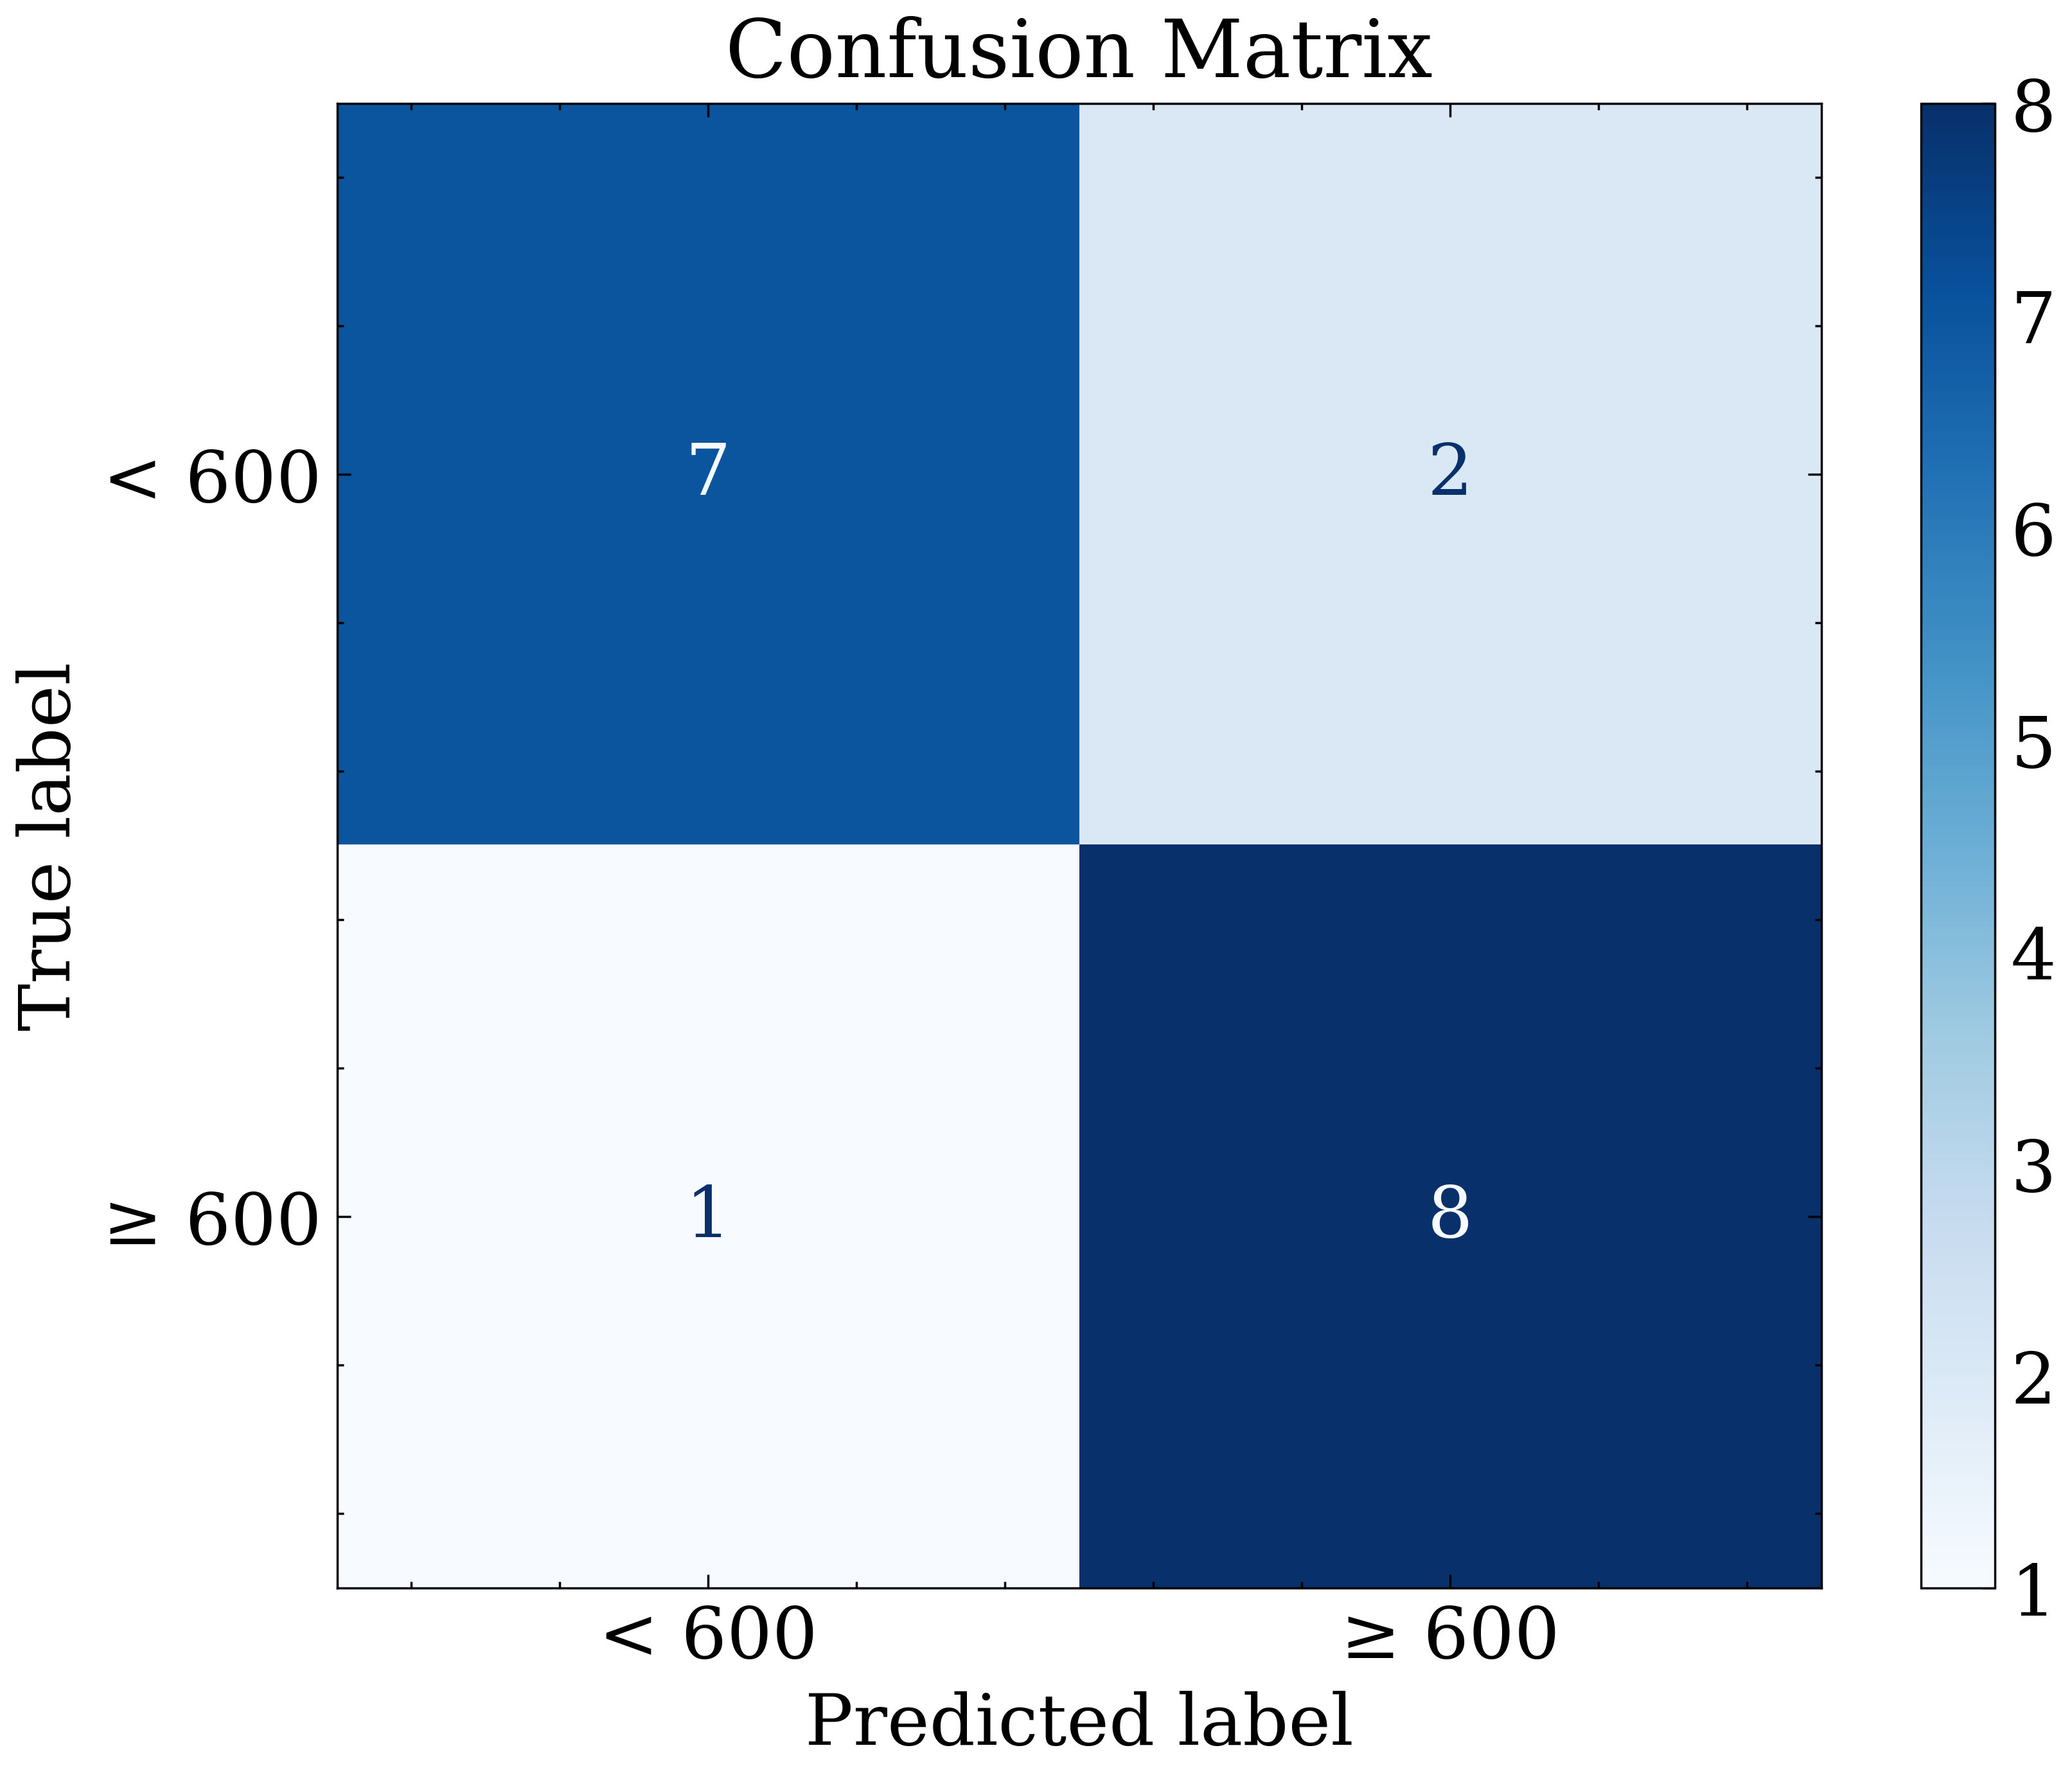

In [16]:
def generate_confusion_matrix(model, test_loader, device, num_classes=1):
    """
    Generates and plots a confusion matrix for a given model and test_loader.

    Args:
        model (torch.nn.Module): Trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): Device (CPU or GPU) to use.
        num_classes (int): Number of classes. 1 for binary classification.
        output_dir (str): Directory to save the confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []
    results = []  

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            images = batch['image'].to(device)  # [B, C, D, H, W]
            labels = batch['label'].to(device)  # [B]
            patient_id = batch['patient_id']
            print(f"Patient id {patient_id}: True label = {labels}")
            # Assume the model takes both images and clinical_data
            clinical_data = batch['clinical_features'].to(device)  # [B, clinical_dim]
            outputs = model(images, clinical_data)  # [B, num_classes]

            if num_classes == 1:
                # Binary classification with sigmoid
                probs = torch.sigmoid(outputs).view(-1)  
                preds = (probs >= 0.5).long()
                labels = labels.long()
                print(f"Predicted: {preds} for patient id {patient_id}")
            else:
                # Multiclass with softmax
                probs = F.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
                labels = labels.long()

            # Save predictions and corresponding labels
            all_preds.extend(preds.cpu().numpy().tolist())  # Convert to list
            all_labels.extend(labels.cpu().numpy().tolist())

            # Save predictions in a dictionary format
            for i in range(len(patient_id)):
                results.append({
                    "patient_id": patient_id[i],
                    "true_label": labels.cpu().numpy().tolist()[i],
                    "predicted_label": preds.cpu().numpy().tolist()[i],
                    "probability": probs.cpu().numpy().tolist()[i]
                })

            print(f"Batch {batch_idx + 1}/{len(test_loader)} processed.")

    # Compute confusion matrix
    if num_classes == 1:
        cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
        classes = ['\u003C 600', '\u2265 600']

    else:
        cm = confusion_matrix(all_labels, all_preds)
        classes = [f'Class {i}' for i in range(num_classes)]

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')

    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.savefig('{DIR}/confusion_matrix_DL_survival.pdf')
    plt.show()
    plt.close()

    return results
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

predictions = generate_confusion_matrix(model, test_loader, device, num_classes=num_classes)

# Model Interpretability

Model attention was visualized using Grad-CAM applied to the CNNViT architecture.  
All generated plots are saved in the `GradCamPlots` directory in the GitHub repository.

Some inspiration for the implementation was taken from [this Medium tutorial by Stepan Ulyanin](https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82).


In [ ]:
# Print the entire dual_unet structure
print("Dual CNN structure:")
print(model.dual_cnn)

# Print all submodules of dual_unet
print("\nDual CNN submodules:")
for name, module in model.dual_cnn.named_children():
    print(name, module)

# Print the encoder_t1 layers
print("\nBranch_t1 layers:")
for name, layer in model.dual_cnn.branch_t1.named_children():
    print(name, layer)

# Print the encoder_t2 layers (if applicable)
print("\nBranch_t2 layers:")
for name, layer in model.dual_cnn.branch_t2.named_children():
    print(name, layer)

# Select target_layer from, for example, encoder_t1
target_layer = list(model.dual_cnn.branch_t1.children())[-1][3]
print("\nSelected target_layer from encoder_t1:", target_layer)

In [ ]:
# GradCAM for 3D data over two branches (T1CE and T2-FLAIR)
class GradCAM3DTotal:
    def __init__(self, model, target_layer_t1, target_layer_t2):
        self.model = model
        self.model.eval()
        self.target_layer_t1 = target_layer_t1
        self.target_layer_t2 = target_layer_t2
        self.gradients_t1 = None
        self.activations_t1 = None
        self.gradients_t2 = None
        self.activations_t2 = None
        self.register_hooks()

    def save_gradient_t1(self, grad):
        self.gradients_t1 = grad

    def save_gradient_t2(self, grad):
        self.gradients_t2 = grad

    def register_hooks(self):
        def forward_hook_t1(module, input, output):
            self.activations_t1 = output
            self.activations_t1.register_hook(self.save_gradient_t1)
        def forward_hook_t2(module, input, output):
            self.activations_t2 = output
            self.activations_t2.register_hook(self.save_gradient_t2)
        self.target_layer_t1.register_forward_hook(forward_hook_t1)
        self.target_layer_t2.register_forward_hook(forward_hook_t2)

    def __call__(self, x, clinical_data, class_idx=None):
        device = next(self.model.parameters()).device
        x = x.clone().detach().requires_grad_(True).to(device)
        clinical_data = clinical_data.clone().detach().to(device)
        output = self.model(x, clinical_data)

        if class_idx is None:
            if output.size(1) == 1:
                class_idx = torch.zeros(output.size(0), dtype=torch.long).to(x.device)
            else:
                class_idx = torch.argmax(output, dim=1)

        if x.size(0) != 1:
            raise ValueError("Batch size must be 1 for Grad-CAM visualization.")

        score = output[0, class_idx[0]]
        self.model.zero_grad()
        score.backward()

        # Debug prints for gradients and activations from both branches
        print("Encoder T1: Min gradient:", self.gradients_t1.min().item(), "Max gradient:", self.gradients_t1.max().item())
        print("Encoder T1: Min activation:", self.activations_t1.min().item(), "Max activation:", self.activations_t1.max().item())
        print("Encoder T2: Min gradient:", self.gradients_t2.min().item(), "Max gradient:", self.gradients_t2.max().item())
        print("Encoder T2: Min activation:", self.activations_t2.min().item(), "Max activation:", self.activations_t2.max().item())

        # Compute CAM for encoder T1
        gradients_t1 = self.gradients_t1[0]   # [C, D, H, W]
        activations_t1 = self.activations_t1[0]  # [C, D, H, W]
        if gradients_t1 is None or activations_t1 is None:
            raise ValueError("No gradients or activations recorded for encoder T1.")
        weights_t1 = torch.mean(gradients_t1, dim=(1, 2, 3))  # [C]
        cam_t1 = torch.zeros(activations_t1.shape[1:], dtype=torch.float32, device=device)  # [D, H, W]
        for i, w in enumerate(weights_t1):
            cam_t1 += w * activations_t1[i]
        cam_t1 = cam_t1 - cam_t1.min()
        if cam_t1.max() > 0:
            cam_t1 = cam_t1 / cam_t1.max()

        # Compute CAM for encoder T2
        gradients_t2 = self.gradients_t2[0]   # [C, D, H, W]
        activations_t2 = self.activations_t2[0]  # [C, D, H, W]
        if gradients_t2 is None or activations_t2 is None:
            raise ValueError("No gradients or activations recorded for encoder T2.")
        weights_t2 = torch.mean(gradients_t2, dim=(1, 2, 3))  # [C]
        cam_t2 = torch.zeros(activations_t2.shape[1:], dtype=torch.float32, device=device)  # [D, H, W]
        for i, w in enumerate(weights_t2):
            cam_t2 += w * activations_t2[i]
        cam_t2 = cam_t2 - cam_t2.min()
        if cam_t2.max() > 0:
            cam_t2 = cam_t2 / cam_t2.max()

        # Sum the CAMs from both branches to obtain the total CAM
        total_cam = cam_t1 + cam_t2
        total_cam = total_cam - total_cam.min()
        if total_cam.max() > 0:
            total_cam = total_cam / total_cam.max()

        # Clear stored gradients and activations
        self.gradients_t1 = None
        self.activations_t1 = None
        self.gradients_t2 = None
        self.activations_t2 = None

        return total_cam, output

def visualize_gradcam_2d(cam_slice, original_image_slice, predicted_label, actual_label, sample_idx, output_dir, upsample_size=None):
    """
    Visualizes a 2D slice with CAM overlay and displays the predicted and actual labels.
    Saves the plot as an image file in output_dir.
    """
    cam_slice_np = cam_slice.detach().cpu().numpy()
    if upsample_size is not None:
        cam_slice_resized = cv2.resize(cam_slice_np, upsample_size, interpolation=cv2.INTER_LINEAR)
    else:
        cam_slice_resized = cam_slice_np

    plt.figure(figsize=(10, 5))
    # Original image with labels
    plt.subplot(1, 2, 1)
    plt.title(f"Patient id: {predicted_label['patient_id'].item()}\nActual Label: {actual_label.item()}, Predicted Label: {predicted_label['predicted_label']}")
    plt.imshow(original_image_slice, cmap="gray")
    plt.axis('off')
    # Grad-CAM Overlay
    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Overlay")
    plt.imshow(original_image_slice, cmap="gray")
    plt.imshow(cam_slice_resized, cmap="jet", alpha=0.5)
    plt.colorbar()
    plt.axis('off')

    os.makedirs(output_dir, exist_ok=True)
    plot_path = os.path.join(output_dir, f"gradcam_sample_{sample_idx}.pdf")
    plt.savefig(plot_path)
    plt.show()
    plt.close()
    print(f"Saved Grad-CAM plot for sample {sample_idx} at {plot_path}")

# --- Initialization and integration with your CNNViT model ---

target_layer_t1 = list(model.dual_cnn.branch_t1.children())[-1][3]
target_layer_t2 = list(model.dual_cnn.branch_t2.children())[-1][3]
print("Selected target layers:\nT1 branch:", target_layer_t1, "\nT2 branch:", target_layer_t2)

grad_cam = GradCAM3DTotal(model, target_layer_t1, target_layer_t2)

# Define output directory for saved plots
output_dir = f"{DIR}/gradcam_plots"

# Example loop through test_loader
for batch_idx, batch in enumerate(test_loader):
    images = batch['image']           # [B, 3, D, H, W]
    labels = batch['label']           # [B]
    patient_id = batch['patient_id']
    prediction = next((item for item in predictions if item["patient_id"] == patient_id), None)
    clinical_datas = batch['clinical_features']  # [B, clinical_dim]
    batch_size = images.size(0)
    print(f"\nProcessing batch {batch_idx + 1}/{len(test_loader)} with batch size {batch_size}")

    for i in range(batch_size):
        sample_idx = batch_idx * batch_size + i + 1  # Unique index for each sample
        # We pass only the first two channels (T1CE & T2-FLAIR) to the CNN branch via dual_cnn.
        # The clinical data is passed unchanged.
        image = images[i].unsqueeze(0).to(device)      # [1, 3, D, H, W]
        label = labels[i].to(device)
        clinical_data = clinical_datas[i].unsqueeze(0).to(device)

        print(f"\nProcessing sample {sample_idx}")
        print("Image shape:", image.shape)
        print("Label:", label)
        print("Clinical data:", clinical_data)

        try:
            # Compute total CAM and get model output
            total_cam, output = grad_cam(image, clinical_data)
            print("Total CAM shape:", total_cam.shape)

            # Interpolate CAM to original image resolution (D, H, W)
            _, C, D, H, W = image.shape
            cam_upsampled = F.interpolate(total_cam.unsqueeze(0).unsqueeze(0), size=(D, H, W), mode='trilinear', align_corners=False)
            cam_upsampled = cam_upsampled.squeeze(0).squeeze(0)  # [D, H, W]
            print("Upsampled CAM shape:", cam_upsampled.shape)

            # Find the slice with the highest average CAM value
            cam_mean_per_slice = cam_upsampled.mean(dim=(1, 2))  # [D]
            slice_idx = torch.argmax(cam_mean_per_slice).item()
            print(f"Slice with most focus: {slice_idx}")

            cam_slice = cam_upsampled[slice_idx]  # [H, W]

            # Example: Create an average slice of the first 2 channels (T1CE and T2-FLAIR) for visualization
            original_image_slice = image[0, :2, slice_idx].float().mean(dim=0).detach().cpu().numpy()  # [H, W]

            # Visualize and save Grad-CAM
            visualize_gradcam_2d(
                cam_slice,
                original_image_slice,
                predicted_label=prediction,
                actual_label=label,
                sample_idx=sample_idx,
                output_dir=output_dir,
                upsample_size=None
            )

            # Clean up to free memory
            del total_cam, output, cam_upsampled, cam_slice, original_image_slice
            del image, label, clinical_data
            torch.cuda.empty_cache()

        except Exception as e:
            print(f"Error processing sample {sample_idx}: {e}")
            torch.cuda.empty_cache()
            continue


In [ ]:
def aggregate_gradcam3d_by_pred(predictions, test_loader, grad_cam, device):
    """
    Iterates through the entire test set, computes the total Grad-CAM3D for each sample,
    upsamples the CAM to the original resolution, and extracts the middle slice (based on
    the depth dimension). Based on the stored predictions (in 'predictions'), the 2D CAM
    (middle slice) is aggregated separately for each class.

    Args:
        predictions (list): List of dictionaries with prediction info.
        test_loader (DataLoader): Test DataLoader (expected batch_size = 1).
        grad_cam (GradCAM3DTotal): Instance of GradCAM3DTotal.
        device (torch.device): The device (CPU/GPU).

    Returns:
        tuple: (aggregated_cam_0, aggregated_cam_1)
               Each is a numpy array with shape [H, W] – the aggregated (average) middle-slice CAM for the respective class.
    """
    # Lists to store the middle slice CAMs for each sample per class
    cams_class0 = []
    cams_class1 = []
    sample_counter = 0

    for batch_idx, batch in enumerate(test_loader):
        images = batch['image']         # [B, C, D, H, W]
        clinical_datas = batch['clinical_features']  # [B, clinical_dim]
        batch_size = images.size(0)
        print(f"\nProcessing batch {batch_idx+1}/{len(test_loader)} with batch size {batch_size}")

        for i in range(batch_size):
            sample_counter += 1
            image = images[i].unsqueeze(0).to(device)         # [1, C, D, H, W]
            clinical_data = clinical_datas[i].unsqueeze(0).to(device)  # [1, clinical_dim]

            try:
                # Compute the total CAM with GradCAM3DTotal (assumes it returns a normalized CAM)
                total_cam, _ = grad_cam(image, clinical_data)  # total_cam: [D', H', W']
                # Upsample CAM to original resolution
                _, C, D, H, W = image.shape
                cam_upsampled = F.interpolate(total_cam.unsqueeze(0).unsqueeze(0),
                                              size=(D, H, W), mode='trilinear', align_corners=False)
                cam_upsampled = cam_upsampled.squeeze(0).squeeze(0)  # [D, H, W]

                # Extract the middle slice along the depth dimension
                mid_slice_idx = D // 2
                cam_middle = cam_upsampled[mid_slice_idx]  # [H, W]

                # Retrieve prediction info for the sample (assumes predictions list order matches)
                pred_info = predictions[sample_counter - 1]
                predicted_label = pred_info["predicted_label"]

                # Collect the middle slice for the respective predicted class
                cam_np = cam_middle.detach().cpu().numpy()
                if predicted_label == 0:
                    cams_class0.append(cam_np)
                elif predicted_label == 1:
                    cams_class1.append(cam_np)

            except Exception as e:
                print(f"Error processing sample {sample_counter}: {e}")
                continue

    # Compute the average CAM for each class if samples exist
    aggregated_cam_0 = np.mean(cams_class0, axis=0) if cams_class0 else None
    aggregated_cam_1 = np.mean(cams_class1, axis=0) if cams_class1 else None

    print(f"Aggregated over {len(cams_class0)} samples for prediction 0 and {len(cams_class1)} samples for prediction 1.")
    return aggregated_cam_0, aggregated_cam_1

def visualize_aggregated_gradcam3d_separate(aggregated_cam, class_label):
    """
    Visualizes an aggregated Grad-CAM3D middle-slice by displaying it as a 2D heatmap.
    This function plots the visualization separately for each class.

    Args:
        aggregated_cam (numpy.ndarray): 2D CAM with shape [H, W].
        class_label (int): Predicted class (e.g., 0 or 1).
    """
    if aggregated_cam is None:
        print(f"No samples for class {class_label}.")
        return

    # Normalize the aggregated CAM
    aggregated_cam = aggregated_cam - np.min(aggregated_cam)
    if np.max(aggregated_cam) != 0:
        aggregated_cam = aggregated_cam / np.max(aggregated_cam)

    plt.figure(figsize=(6, 6))
    plt.imshow(aggregated_cam, cmap='jet')
    plt.title(f"Aggregated Grad-CAM for predicted class {class_label}")
    plt.colorbar()
    plt.axis("off")
    plt.savefig(f"{DIR}/{class_label}.pdf")
    plt.show()


if __name__ == "__main__":
    num_classes = 1  # Binary classification (0 and 1)
    clinical_dim = 21
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for name, param in model.named_parameters():
        param.requires_grad = True

    # Select target layers from the encoders (e.g., the last layer in each encoder)
    target_layer_t1 = list(model.dual_cnn.branch_t1.children())[-1]
    target_layer_t2 = list(model.dual_cnn.branch_t2.children())[-1]
    print("Selected target layers:\nBranch T1:", target_layer_t1, "\nBranch T2:", target_layer_t2)

    grad_cam_total = GradCAM3DTotal(model, target_layer_t1, target_layer_t2)

    # Aggregate Grad-CAM3D (using the middle slice) for each predicted class
    aggregated_cam_0, aggregated_cam_1 = aggregate_gradcam3d_by_pred(predictions, test_loader, grad_cam_total, device)

    # Visualize separately for each class
    visualize_aggregated_gradcam3d_separate(aggregated_cam_0, class_label=0)
    visualize_aggregated_gradcam3d_separate(aggregated_cam_1, class_label=1)

In [ ]:
for name, module in model.named_modules():
    print(name, module)

In [ ]:
class GradCAMViT:
    def __init__(self, model, target_layer):
        """
        Initializes the GradCAMViT object.

        Args:
            model (nn.Module): The trained model.
            target_layer (nn.Module): The layer to target for Grad-CAM.
        """
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.register_hooks()

    def save_gradient(self, grad):
        """
        Saves the gradients from the target layer.

        Args:
            grad (torch.Tensor): Gradients tensor.
        """
        self.gradients = grad  # Shape: [Batch, Features, D', H', W']

    def register_hooks(self):
        """
        Registers forward and backward hooks to capture activations and gradients.
        """
        def forward_hook(module, input, output):
            print(f"Inside ViT forward_hook: output.requires_grad = {output.requires_grad}")
            self.activations = output  # Shape: [Batch, Features, D', H', W']
            # Register hook to capture gradients during backward pass
            output.register_hook(self.save_gradient)

        self.target_layer.register_forward_hook(forward_hook)

    def __call__(self, x, clinical_data, class_idx=None):
        """
        Generates the Grad-CAM heatmap.

        Args:
            x (torch.Tensor): Input image tensor. Shape: [1, C, D, H, W]
            clinical_data (torch.Tensor): Clinical data tensor. Shape: [1, clinical_dim]
            class_idx (int, optional): Index of the target class. Defaults to None.

        Returns:
            tuple: (Grad-CAM heatmap, Model output)
        """
        device = next(self.model.parameters()).device
        x = x.clone().detach().requires_grad_(True).to(device)
        clinical_data = clinical_data.clone().detach().to(device)

        output = self.model(x, clinical_data)  # Forward pass

        if class_idx is None:
            if output.size(1) == 1:
                class_idx = torch.zeros(output.size(0), dtype=torch.long).to(x.device)
            else:
                class_idx = torch.argmax(output, dim=1)

        if x.size(0) != 1:
            raise ValueError("Batch size must be 1 for Grad-CAM visualization.")

        score = output[0, class_idx[0]]  # Target score
        self.model.zero_grad()
        score.backward()  # Backward pass to compute gradients

        gradients = self.gradients  # Captured gradients [1, Features, D', H', W']
        activations = self.activations  # Captured activations [1, Features, D', H', W']

        if gradients is None or activations is None:
            raise ValueError("No gradients or activations recorded.")

        # Compute weights: global average pooling on gradients across spatial dimensions
        weights = torch.mean(gradients, dim=(2, 3, 4))  # Shape: [Batch, Features]

        # Compute the weighted sum of activations
        cam = torch.zeros(activations.shape[2:], dtype=torch.float32, device=device)  # Shape: [D', H', W']
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i, :, :, :]

        cam = F.relu(cam)  # Apply ReLU
        cam -= cam.min()
        if cam.max() != 0:
            cam /= cam.max()  # Normalize between 0 and 1

        return cam.detach(), output  # Return both CAM and model output


# Visualization function for 2D Grad-CAM with dose distribution
def visualize_gradcam_2d(cam_slice, dose_slice, original_image_slice, predicted_label, actual_label, sample_idx, upsample_size=None):
    """
    Visualizes a 2D slice with an overlay of the CAM and dose distribution, and displays the predicted and actual labels.
    The plot is shown immediately.

    Args:
        cam_slice (torch.Tensor): Grad-CAM heatmap for a single slice. Shape: [H, W]
        dose_slice (torch.Tensor): Dose distribution heatmap for a single slice. Shape: [H, W]
        original_image_slice (numpy.ndarray): Original image slice. Shape: [H, W]
        predicted_label (int or dict): The model's predicted class. May also contain additional info (e.g., patient id).
        actual_label (torch.Tensor): The actual class.
        sample_idx (int): Index of the sample.
        upsample_size (tuple, optional): Desired resolution for upscaling. Defaults to None.
    """
    cam_slice_np = cam_slice.cpu().numpy()  # Convert to NumPy
    dose_slice_np = dose_slice.cpu().numpy()  # Convert to NumPy

    if upsample_size is not None:
        cam_slice_resized = cv2.resize(cam_slice_np, upsample_size, interpolation=cv2.INTER_LINEAR)
        dose_slice_resized = cv2.resize(dose_slice_np, upsample_size, interpolation=cv2.INTER_LINEAR)
        original_image_resized = cv2.resize(original_image_slice, upsample_size, interpolation=cv2.INTER_LINEAR)
    else:
        cam_slice_resized = cam_slice_np
        dose_slice_resized = dose_slice_np
        original_image_resized = original_image_slice

    plt.figure(figsize=(15, 5))

    # Original image slice with labels
    plt.subplot(1, 2, 1)
    plt.title(f"Patient id {predicted_label['patient_id']}\nActual Label: {actual_label.item()}, Predicted Label: {predicted_label['predicted_label']}")
    plt.imshow(original_image_resized, cmap="gray")
    plt.axis('off')

    # Grad-CAM overlay
    plt.subplot(1, 2, 2)
    plt.title("Dose Grad-CAM Overlay")
    plt.imshow(original_image_resized, cmap="gray")
    plt.imshow(dose_slice_resized, cmap="jet", alpha=0.5)  # 'jet' colormap with moderate alpha
    plt.imshow(cam_slice_resized, cmap="gray", alpha=0.8)  # Grayscale with high alpha
    plt.colorbar()
    plt.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.savefig(f"{DIR}/gradcam_ViT_sample_{sample_idx}.pdf")
    plt.show()


# Function to map Grad-CAM features back to spatial dimensions (for ViT)
def map_gradcam_to_patches(cam_features, patch_embed, D, H, W):
    """
    Maps Grad-CAM features back to their corresponding 3D patches in the input image.

    Args:
        cam_features (torch.Tensor): Grad-CAM heatmap. Shape: [D', H', W']
        patch_embed (nn.Module): The PatchEmbed3D module from the model.
        D (int): Depth of the input image.
        H (int): Height of the input image.
        W (int): Width of the input image.

    Returns:
        numpy.ndarray: 3D Grad-CAM heatmap. Shape: [D, H, W]
    """
    # Retrieve patch size and stride from PatchEmbed3D
    patch_size = patch_embed.proj.kernel_size  # (e.g., (4, 16, 16))
    stride = patch_embed.proj.stride  # (e.g., (4, 16, 16))

    # Calculate number of patches along each dimension
    num_patches_d = (D - patch_size[0]) // stride[0] + 1
    num_patches_h = (H - patch_size[1]) // stride[1] + 1
    num_patches_w = (W - patch_size[2]) // stride[2] + 1

    # Initialize 3D heatmap
    cam_heatmap = torch.zeros(D, H, W).to(cam_features.device)

    # Iterate over each patch and assign Grad-CAM score
    for d in range(num_patches_d):
        for h in range(num_patches_h):
            for w in range(num_patches_w):
                # Retrieve CAM score for this patch as a scalar
                score = cam_features[d, h, w].item()

                # Calculate the spatial location of the patch
                d_start = d * stride[0]
                h_start = h * stride[1]
                w_start = w * stride[2]
                d_end = d_start + patch_size[0]
                h_end = h_start + patch_size[1]
                w_end = w_start + patch_size[2]

                # Assign the Grad-CAM score to the patch region
                cam_heatmap[d_start:d_end, h_start:h_end, w_start:w_end] += score

    # Normalize the heatmap
    cam_heatmap = F.relu(cam_heatmap)
    cam_heatmap -= cam_heatmap.min()
    if cam_heatmap.max() != 0:
        cam_heatmap /= cam_heatmap.max()

    # Handle any remaining slices
    if D > cam_heatmap.shape[0]:
        pad_d = D - cam_heatmap.shape[0]
        cam_heatmap = F.pad(cam_heatmap, (0, 0, 0, 0, 0, pad_d), "constant", 0)

    return cam_heatmap.detach().cpu().numpy()  # Detach before converting to NumPy


# Extract dose distribution (can be adapted as needed)
def extract_dose_distribution(image_tensor):
    """
    Extracts the dose distribution from the image.

    Args:
        image_tensor (torch.Tensor): Image tensor. Shape: [1, C, D, H, W]

    Returns:
        numpy.ndarray: 3D dose distribution heatmap. Shape: [D, H, W]
    """
    # Assume that the dose distribution is in the third channel (can be adjusted as needed)
    dose_image = image_tensor[0, 2, :, :, :]  # [D, H, W]
    dose_heatmap = dose_image.cpu().numpy()

    # Normalize the dose distribution to [0,1]
    dose_heatmap -= dose_heatmap.min()
    if dose_heatmap.max() != 0:
        dose_heatmap /= dose_heatmap.max()

    return dose_heatmap


# Updated main function to visualize Grad-CAM in 2D for ViT
def visualize_gradcam_vit_2d():
    """
    Main function to initialize the model, compute Grad-CAM, and visualize it in 2D.
    """
    # Initialize model and test_loader (assumes that best_model and test_loader are defined)
    num_classes = 1  # Adjust as needed
    clinical_dim = 21

    # Ensure all model parameters require gradients (for Grad-CAM)
    for name, param in model.named_parameters():
        if not param.requires_grad:
            print(f"Parameter {name} does not require gradients.")
        param.requires_grad = True  # Force all parameters to require gradients

    # Identify the Vision Transformer component
    vision_transformer = model.vision_transformer

    # Target layer: the channel_mixer layer within PatchEmbed3D (adjust according to your model structure)
    target_layer_vit = vision_transformer.patch_embed.channel_mixer
    print("Selected ViT target_layer:", target_layer_vit)

    # Initialize Grad-CAM for the Vision Transformer
    grad_cam_vit = GradCAMViT(model, target_layer_vit)

    # Iterate through all batches in the test_loader
    for batch_idx, batch in enumerate(test_loader):
        # Assume that test_loader returns a dictionary with keys 'image', 'label', 'clinical_features'
        images = batch['image']  # [B, C, D, H, W]
        labels = batch['label']  # [B]
        clinical_datas = batch['clinical_features']  # [B, clinical_dim]

        batch_size = images.size(0)
        print(f"\nProcessing batch {batch_idx + 1}/{len(test_loader)} with batch size {batch_size}")

        for i in range(batch_size):
            sample_idx = batch_idx * batch_size + i + 1  # Unique index
            image = images[i].unsqueeze(0).to(device)  # [1, C, D, H, W]
            label = labels[i].to(device)  # [1]
            clinical_data = clinical_datas[i].unsqueeze(0).to(device)  # [1, clinical_dim]
            patient_id = batch['patient_id'][i]
            prediction = next((item for item in predictions if item["patient_id"] == patient_id), None)

            print(f"\nProcessing sample {sample_idx}")
            print("Image shape:", image.shape)  # [1, C, D, H, W]
            print("Label:", label)
            print("Clinical data:", clinical_data)

            try:
                # Compute CAM and get the model output
                cam_vit, output = grad_cam_vit(image, clinical_data)  # cam_vit: [D', H', W'], output: [B, num_classes]
                print("ViT CAM shape:", cam_vit.shape)

                # Map Grad-CAM features back to spatial dimensions
                D, H, W = image.shape[2], image.shape[3], image.shape[4]
                cam_heatmap_3d = map_gradcam_to_patches(cam_vit, vision_transformer.patch_embed, D, H, W)  # Shape: [D, H, W]

                # Find the slice with the highest CAM value (most focus)
                cam_mean_per_slice = cam_heatmap_3d.mean(axis=(1, 2))  # [D]
                slice_idx = np.argmax(cam_mean_per_slice)
                print(f"Slice with most focus: {slice_idx}")

                cam_slice = torch.tensor(cam_heatmap_3d[slice_idx])  # [H, W]

                # Extract the dose distribution for this slice
                dose_heatmap_3d = extract_dose_distribution(image)  # Shape: [D, H, W]
                dose_slice = torch.tensor(dose_heatmap_3d[slice_idx])  # [H, W]

                # Actual label
                actual_label = label

                # Example: take an average slice of the first 2 channels from the original image for visualization.
                # Here, we take the first 2 channels (since the model expects 2 channels in UNet).
                original_image_slice = image[0, :2, slice_idx].mean(dim=0).detach().cpu().numpy()  # [H, W]

                # Visualize Grad-CAM in 2D with dose distribution
                visualize_gradcam_2d(
                    cam_slice,
                    dose_slice,
                    original_image_slice,
                    prediction,
                    actual_label,
                    sample_idx,
                    upsample_size=None
                )
            except Exception as e:
                print(f"Error processing sample {sample_idx}: {e}")
                continue

if __name__ == "__main__":
    visualize_gradcam_vit_2d()

In [ ]:
def aggregate_dose_by_prediction(predictions: list, test_loader: DataLoader, device: torch.device):
    """
    Iterates over the test set and aggregates dose distribution heatmaps separately
    for samples with prediction 0 and prediction 1.

    Args:
        predictions (list): List of dictionaries with keys "patient_id", "true_label",
                            "predicted_label", and "probability".
        test_loader (DataLoader): Test DataLoader (expected batch_size=1).
        device (torch.device): Device to use (CPU or GPU).

    Returns:
        tuple: (aggregated_dose_pred0, aggregated_dose_pred1) where each is a 3D numpy array.
    """
    aggregated_dose_pred0 = None
    aggregated_dose_pred1 = None
    count_pred0 = 0
    count_pred1 = 0

    # Assumes that the order of samples in test_loader corresponds to the order in predictions.
    for idx, batch in enumerate(test_loader):
        # Retrieve the image and move it to the appropriate device.
        image = batch['image'].to(device)  # [1, C, D, H, W]

        # Extract the dose distribution using an existing function.
        # Assumes extract_dose_distribution returns a numpy array of shape [D, H, W].
        dose_heatmap_3d = extract_dose_distribution(image)

        # Get the prediction from the predictions list.
        pred = predictions[idx]['predicted_label']

        if pred == 0:
            if aggregated_dose_pred0 is None:
                aggregated_dose_pred0 = dose_heatmap_3d.copy()
            else:
                aggregated_dose_pred0 += dose_heatmap_3d
            count_pred0 += 1
        elif pred == 1:
            if aggregated_dose_pred1 is None:
                aggregated_dose_pred1 = dose_heatmap_3d.copy()
            else:
                aggregated_dose_pred1 += dose_heatmap_3d
            count_pred1 += 1

    # Normalize by averaging each group (if sample count > 0)
    if count_pred0 > 0:
        aggregated_dose_pred0 /= count_pred0
    if count_pred1 > 0:
        aggregated_dose_pred1 /= count_pred1

    return aggregated_dose_pred0, aggregated_dose_pred1
def visualize_aggregated_dose_by_prediction(predictions: list, test_loader: DataLoader, device: torch.device):
    """
    Visualizes the aggregated dose distribution for the two groups (prediction 0 and 1)
    by averaging over the depth (D) for each group and plotting them side by side with
    a color scale fixed between 0 and 1.
    """
    aggregated_dose_pred0, aggregated_dose_pred1 = aggregate_dose_by_prediction(predictions, test_loader, device)

    # Compute 2D projections if available
    dose_proj_pred0 = np.mean(aggregated_dose_pred0, axis=0) if aggregated_dose_pred0 is not None else None
    dose_proj_pred1 = np.mean(aggregated_dose_pred1, axis=0) if aggregated_dose_pred1 is not None else None

    plt.figure(figsize=(12, 5))

    # Plot for prediction 0 with fixed color scale from 0 to 1
    plt.subplot(1, 2, 1)
    if dose_proj_pred0 is not None:
        img0 = plt.imshow(dose_proj_pred0, cmap='jet', vmin=0, vmax=1)
        plt.title("Prediction 0 (<600 days)")
        plt.xticks([])
        plt.yticks([])

        plt.colorbar(img0)
    else:
        plt.text(0.5, 0.5, 'No samples with prediction 0',
                 horizontalalignment='center', verticalalignment='center')
        plt.axis('off')

    # Plot for prediction 1 with fixed color scale from 0 to 1
    plt.subplot(1, 2, 2)
    if dose_proj_pred1 is not None:
        img1 = plt.imshow(dose_proj_pred1, cmap='jet', vmin=0, vmax=1)
        plt.title("Prediction 1 (>600 days)")
        plt.xticks([])
        plt.yticks([])

        plt.colorbar(img1)
    else:
        plt.text(0.5, 0.5, 'No samples with prediction 1',
                 horizontalalignment='center', verticalalignment='center')
        plt.axis('off')

    plt.suptitle("Aggregated Dose Distribution by Model Prediction")
    plt.tight_layout()
    plt.savefig(f"{DIR}/aggregated_dose_by_prediction.pdf")
    plt.show()

visualize_aggregated_dose_by_prediction(predictions, test_loader, device)

In [ ]:
def aggregate_gradcam_patches_by_pred(predictions, test_loader, grad_cam_vit, vision_transformer, device, num_classes=1):
    """
    Iterates through the entire test set, computes Grad-CAM for each sample, maps the CAM back to
    full 3D, and then extracts the middle slice. The middle CAM patch is then aggregated separately
    for samples with prediction 0 and 1.

    Args:
        predictions (list): List of dictionaries with prediction info (as generated by generate_confusion_matrix).
        test_loader (DataLoader): Test DataLoader (expected batch_size=1).
        grad_cam_vit (GradCAMViT): Instance of GradCAMViT.
        vision_transformer: The Vision Transformer component of the model to retrieve patch_embed.
        device (torch.device): CPU/GPU.
        num_classes (int): Number of classes (1 for binary classification).

    Returns:
        tuple: (aggregated_cam_0, aggregated_cam_1)
               Each is a numpy array with shape [H, W] – the aggregated middle-slice CAM for the respective class.
    """
    aggregated_cam_0 = None
    aggregated_cam_1 = None
    count_0 = 0
    count_1 = 0

    sample_counter = 0

    # Iterate through all samples in the test_loader
    for batch_idx, batch in enumerate(test_loader):
        images = batch['image']         # [B, C, D, H, W]
        clinical_datas = batch['clinical_features']  # [B, clinical_dim]
        batch_size = images.size(0)
        print(f"\nProcessing batch {batch_idx + 1}/{len(test_loader)} with batch size {batch_size}")

        for i in range(batch_size):
            sample_counter += 1
            image = images[i].unsqueeze(0).to(device)         # [1, C, D, H, W]
            clinical_data = clinical_datas[i].unsqueeze(0).to(device)  # [1, clinical_dim]

            try:
                # Compute Grad-CAM for the sample
                cam_vit, _ = grad_cam_vit(image, clinical_data)  # cam_vit: [D', H', W']
                # Map the CAM back to full 3D
                D, H, W = image.shape[2], image.shape[3], image.shape[4]
                cam_heatmap_3d = map_gradcam_to_patches(cam_vit, vision_transformer.patch_embed, D, H, W)  # [D, H, W]

                # Extract the middle slice along the depth dimension
                mid_slice_idx = D // 2
                cam_mid_slice = cam_heatmap_3d[mid_slice_idx]  # [H, W]

                # Retrieve the prediction for the sample from the predictions list
                # Here we assume that the order in predictions corresponds to the order in test_loader.
                pred_info = predictions[sample_counter - 1]
                predicted_label = pred_info["predicted_label"]

                # Accumulate the middle slice CAM for each class
                if predicted_label == 0:
                    if aggregated_cam_0 is None:
                        aggregated_cam_0 = np.array(cam_mid_slice)
                    else:
                        aggregated_cam_0 += cam_mid_slice
                    count_0 += 1
                elif predicted_label == 1:
                    if aggregated_cam_1 is None:
                        aggregated_cam_1 = np.array(cam_mid_slice)
                    else:
                        aggregated_cam_1 += cam_mid_slice
                    count_1 += 1

            except Exception as e:
                print(f"Error processing sample {sample_counter}: {e}")
                continue

    # Compute the average CAM for each class (if samples exist)
    if count_0 > 0:
        aggregated_cam_0 = aggregated_cam_0 / count_0
    if count_1 > 0:
        aggregated_cam_1 = aggregated_cam_1 / count_1

    print(f"Aggregated over {count_0} samples for prediction 0 and {count_1} samples for prediction 1.")
    return aggregated_cam_0, aggregated_cam_1


def get_single_color_cmap(color):
    """
    Creates a colormap that varies from white to the specified color.
    The `color` should be an (R, G, B) tuple with values between 0 and 1.
    """
    cdict = {
        'red':   [(0.0, 1.0, 1.0), (1.0, color[0], color[0])],
        'green': [(0.0, 1.0, 1.0), (1.0, color[1], color[1])],
        'blue':  [(0.0, 1.0, 1.0), (1.0, color[2], color[2])]
    }
    return LinearSegmentedColormap('SingleColorMap', segmentdata=cdict, N=256)

# Choose your single color (e.g., red)
single_color = (1.0, 0.0, 0.0)  # RGB for red
single_color_cmap = get_single_color_cmap(single_color)

def visualize_aggregated_cam_separate(aggregated_cam_0, aggregated_cam_1):
    """
    Visualizes the aggregated Grad-CAM middle slices for each class separately.
    Each 2D CAM (middle slice) is normalized and then displayed using a single color wash.
    """
    # For class 0
    if aggregated_cam_0 is not None:
        proj_0 = aggregated_cam_0.copy()  # Already 2D (H x W)
        # Normalize
        proj_0 = proj_0 - np.min(proj_0)
        if np.max(proj_0) != 0:
            proj_0 = proj_0 / np.max(proj_0)
        plt.figure(figsize=(6, 6))
        plt.imshow(proj_0, cmap=single_color_cmap)
        plt.title("Aggregated Grad-CAM \nPredicted Class 0")
        plt.colorbar()
        plt.axis("off")
        plt.savefig(f"{DIR}/aggregated_gradcam_separate_0.pdf")
        plt.show()
    else:
        print("No samples for class 0.")

    # For class 1
    if aggregated_cam_1 is not None:
        proj_1 = aggregated_cam_1.copy()  # Already 2D (H x W)
        # Normalize
        proj_1 = proj_1 - np.min(proj_1)
        if np.max(proj_1) != 0:
            proj_1 = proj_1 / np.max(proj_1)
        plt.figure(figsize=(6, 6))
        plt.imshow(proj_1, cmap=single_color_cmap)
        plt.title("Aggregated Grad-CAM \nPredicted Class 1")
        plt.colorbar()
        plt.axis("off")
        plt.savefig(f"{DIR}/aggregated_gradcam_separate_1.pdf")
        plt.show()
    else:
        print("No samples for class 1.")

if __name__ == "__main__":
    clinical_dim = 21
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model and retrieve the Vision Transformer component
    model = cnn_vit(num_classes=num_classes, clinical_dim=clinical_dim).to(device)
    model.eval()
    for name, param in model.named_parameters():
        param.requires_grad = True

    vision_transformer = model.vision_transformer
    target_layer_vit = vision_transformer.patch_embed.channel_mixer
    print("Selected ViT target_layer:", target_layer_vit)
    grad_cam_vit = GradCAMViT(model, target_layer_vit)

    # Aggregate Grad-CAM patches (using the middle slice) for each prediction (class 0 and 1)
    aggregated_cam_0, aggregated_cam_1 = aggregate_gradcam_patches_by_pred(
        predictions, test_loader, grad_cam_vit, vision_transformer, device, num_classes=num_classes
    )

    # Visualize separately for each class
    visualize_aggregated_cam_separate(aggregated_cam_0, aggregated_cam_1)